In [1]:
import functools
import jax
import os
import html

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output, display

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html

from src.pods.pods import train
from src.env.Pendulum import InvertedPendulum
import pickle


In [2]:
env = InvertedPendulum()
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

HTML(html.render(env.sys, [state.pipeline_state]))

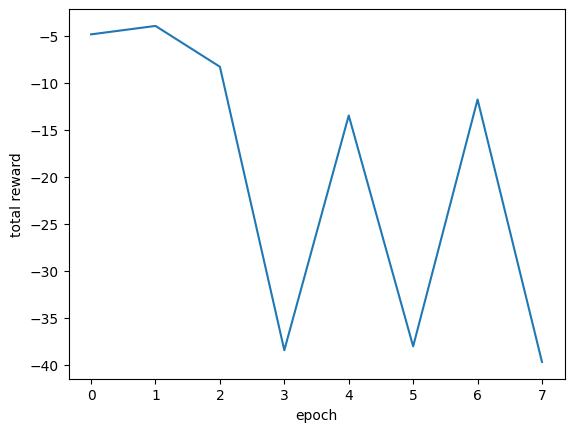

big epoch: 7 small epoch: 0 Loss 126.14093
big epoch: 7 small epoch: 1 Loss 126.10283
big epoch: 7 small epoch: 2 Loss 126.06562
big epoch: 7 small epoch: 3 Loss 126.02904
big epoch: 7 small epoch: 4 Loss 125.99291


KeyboardInterrupt: 

In [3]:

def progress_f(x_data,y_data,epoch,reward):
    x_data.append(epoch)
    y_data.append(reward)
    clear_output(wait=True)
    plt.xlabel('epoch')
    plt.ylabel('total reward')
    plt.plot(x_data, y_data)
    plt.show()

policy = train(env,trajectory_length=30,num_samples=100,epochs=100,alpha_a=0.001,progress_fn=progress_f)

In [ ]:
with open('params.pkl', 'rb') as f:
    params = pickle.load(f)

params = flax.serialization.from_state_dict(params)


TypeError: from_state_dict() missing 1 required positional argument: 'state'